In [1]:
!nvidia-smi

Sat Jun  7 22:07:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!apt-get update -qq
!apt-get install -y nvidia-cuda-toolkit
!nvcc --version

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libaccinj64-11.5 libatk-wrapper-java
  libatk-wrapper-java-jni libbabeltrace1 libcub-dev libcublas11 libcublaslt11
  libcudart11.0 libcufft10 libcufftw10 libcuinj64-11.5 libcupti-dev
  libcupti-doc libcupti11.5 libcurand10 libcusolver11 libcusolvermg11
  libcusparse11 libdebuginfod-common libdebuginfod1 libegl-dev libgail-common
  libgail18 libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglvnd-core-dev
  libglvnd-dev libglx-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libipt2
  libnppc11 libnppial11 libnppicc11 libnppidei11 libnppif11 libnppig11
  libnppim11 libnppist11 libnppisu11 libnppitc11 libnpps11 libnvbl

In [3]:
%%bash
cat > ff_cuda.cu <<'EOF'
#include <cstdio>
#include <cuda_runtime.h>

constexpr int IN  = 4;
constexpr int HID = 5;
constexpr int OUT = 1;
constexpr int BATCH = 1<<20;          // 1 M samples for timing

__global__ void hidden(const float* W, const float* b,
                       const float* x, float* h){
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if(idx >= BATCH * HID) return;
    int sample = idx / HID, neuron = idx % HID;
    float s = b[neuron];
    #pragma unroll
    for(int i=0;i<IN;++i)
        s += W[neuron*IN+i] * x[sample*IN+i];
    h[idx] = s > 0.f ? s : 0.f;       // ReLU
}
__global__ void output(const float* W, const float* b,
                       const float* h, float* y){
    int sample = blockIdx.x * blockDim.x + threadIdx.x;
    if(sample >= BATCH) return;
    float s = b[0];
    #pragma unroll
    for(int i=0;i<HID;++i)
        s += W[i] * h[sample*HID+i];
    y[sample] = s;                    // linear output
}

int main(){
    size_t xBytes = BATCH*IN*sizeof(float);
    size_t hBytes = BATCH*HID*sizeof(float);

    float *dx,*dWh,*dbh,*dWo,*dbo,*dh,*dy;
    cudaMalloc(&dx,xBytes);   cudaMalloc(&dh,hBytes);  cudaMalloc(&dy,BATCH*sizeof(float));
    cudaMalloc(&dWh,HID*IN*sizeof(float));
    cudaMalloc(&dbh,HID*sizeof(float));
    cudaMalloc(&dWo,HID*sizeof(float));
    cudaMalloc(&dbo,OUT*sizeof(float));

    // fill with junk data once (random on host, memcpy is fine)
    float *dummy = (float*)malloc(hBytes> xBytes? hBytes: xBytes);
    cudaMemcpy(dx, dummy, xBytes, cudaMemcpyHostToDevice);
    cudaMemcpy(dWh,dummy,HID*IN*sizeof(float),cudaMemcpyHostToDevice);
    cudaMemcpy(dbh,dummy,HID*sizeof(float),cudaMemcpyHostToDevice);
    cudaMemcpy(dWo,dummy,HID*sizeof(float),cudaMemcpyHostToDevice);
    cudaMemcpy(dbo,dummy,OUT*sizeof(float),cudaMemcpyHostToDevice);

    dim3 block(256);
    cudaEvent_t t0,t1; cudaEventCreate(&t0); cudaEventCreate(&t1);
    cudaEventRecord(t0);
    hidden<<<(BATCH*HID+255)/256,block>>>(dWh,dbh,dx,dh);
    output<<<(BATCH+255)/256,block>>>(dWo,dbo,dh,dy);
    cudaEventRecord(t1); cudaEventSynchronize(t1);
    float ms=0; cudaEventElapsedTime(&ms,t0,t1);
    printf("CUDA forward pass: %.3f ms\\n",ms);
    return 0;
}
EOF

In [4]:
!nvcc -O3 ff_cuda.cu -o ff_cuda
!./ff_cuda

CUDA forward pass: 47.759 ms\n

In [5]:
import torch, time
device='cuda'
BATCH=1<<20
net = torch.nn.Sequential(
    torch.nn.Linear(4,5),
    torch.nn.ReLU(),
    torch.nn.Linear(5,1)
).to(device)

x = torch.randn(BATCH,4,device=device)
torch.cuda.synchronize(); t0=time.perf_counter()
y = net(x)
torch.cuda.synchronize(); t1=time.perf_counter()
print(f"PyTorch forward pass: {(t1-t0)*1e3:.3f} ms")

PyTorch forward pass: 289.832 ms


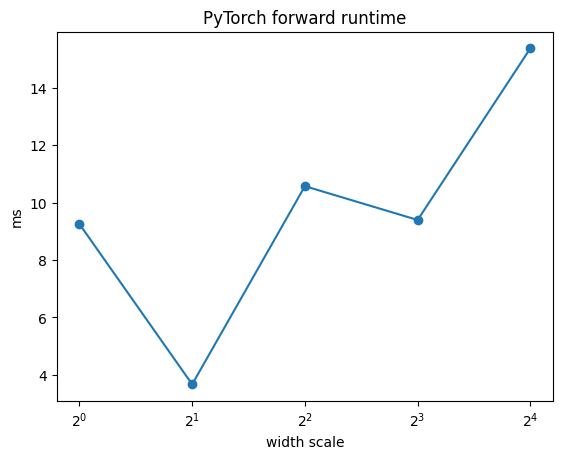

In [6]:
import numpy as np, matplotlib.pyplot as plt
scales=[1,2,4,8,16]
pt=[]
for k in scales:
    net=torch.nn.Sequential(
        torch.nn.Linear(4*k,5*k),torch.nn.ReLU(),
        torch.nn.Linear(5*k,1)
    ).to('cuda')
    x=torch.randn(BATCH,4*k,device='cuda')
    torch.cuda.synchronize(); t0=time.perf_counter()
    net(x);  torch.cuda.synchronize(); t1=time.perf_counter()
    pt.append((k,(t1-t0)*1e3))
plt.plot([s for s,_ in pt],[ms for _,ms in pt],marker='o')
plt.xscale('log',base=2); plt.xlabel('width scale'); plt.ylabel('ms')
plt.title('PyTorch forward runtime'); plt.show()